In [12]:
import numpy as np
import xarray
import rasterio
from matplotlib import pyplot as plt
import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS

# must specific lccs_dev environment for MADs and mangrove datasets
dc = datacube.Datacube(env='lccs_dev', app="level3")

#import le_lccs modules
import sys
sys.path.append("../livingearth_lccs")
from le_lccs.le_ingest import gridded_ingest
from le_lccs.le_classification import lccs_l3

In [13]:
# Define area of interest

# # Ayr
# x = (1500000, 1600000)
# y = (-2200000, -2100000)

# # Diamantina
# x = (800000, 900000)
# y = (-2800000, -2700000)

# # Gwydir
# x = (1600000, 1700000)
# y = (-3400000, -3300000)

# Leichhardt
x = (800000, 900000)
y = (-2000000, -1900000)

# # Kakadu
# x = (0, 100000)
# y = (-1350000, -1250000)

# # Hobart
# x = (1200000, 1300000)
# y = (-4800000, -4700000)

# # Perth
# x = (-1550000, -1450000)
# y = (-3650000, -3550000)

# # Murray Valley
# x = (1100000, 1200000)
# y = (-4000000, -3900000)

# # Adelaide
# x = (550000, 650000)
# y = (-3850000, -3750000)

# # Lake Eyre
# x = (500000, 600000)
# y = (-3000000, -2900000)

# # Blue mountains
# x = (1600000, 1700000)
# y = (-3900000, -3800000)

# # Australian Alps
# x = (1400000, 1500000)
# y = (-4100000, -4000000)

# # Collier Range
# x = (-1300000, -1200000)
# y = (-2700000, -2600000)

# # Coorong
# x = (600000, 700000)
# y = (-3950000, -3850000)

# # Brisbane
# x = (2000000, 2100000)
# y = (-3200000, -3100000)

# # Dundas
# x = (-1000000, -900000)
# y = (-3650000, -3550000)

res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")
sensor = 'ls8'
query =({'x':x,
        'y':y,
        'crs':crs,
        'resolution':res})


In [14]:
# Load mads, normalise, create dataset
mads = dc.load(product=sensor +"_nbart_tmad_annual", measurements=["edev", "sdev", "bcdev"],
               time=time, **query)
mads = masking.mask_invalid_data(mads).squeeze().drop('time')

edev=(mads["edev"])
sdev=(mads["sdev"])
bcdev=(mads["bcdev"])
log_edev = np.log(1/edev)
log_sdev = np.log(1/sdev)
log_bcdev = np.log(1/bcdev)
log_mads = xarray.merge([log_edev, log_sdev, log_bcdev])

# Load FC, create non veg mask, Load WOfS/ITEMS/Mangrove, create non water mask, combine to dataset
fc_ann = dc.load(product="fc_percentile_albers_annual", 
                 measurements=["PV_PC_90", "NPV_PC_90", "BS_PC_90"],
                 time=time, **query)
fc_ann = masking.mask_invalid_data(fc_ann)
vegetat = ((fc_ann["PV_PC_90"] >= 50) | ((fc_ann["NPV_PC_90"] >= 50) & (fc_ann["NPV_PC_90"] <= 80)))
vegetat = np.invert(vegetat)

wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], 
                     time=time, **query)
wofs_ann = masking.mask_invalid_data(wofs_ann)
item = dc.load(product="item_v2", measurements=["relative"], 
                     time=time, **query)
item = masking.mask_invalid_data(item)
item = item.squeeze().drop('time')
mangrove = dc.load(product="mangrove_extent_cover_albers", measurements=["extent"], 
                     time=time, **query)
mangrove = masking.mask_invalid_data(mangrove)

aquatic_wat = ((wofs_ann["frequency"] >= 0.2) | ((item["relative"] >= 2) & (item["relative"] <= 8)) | (mangrove["extent"] == 1))
aquatic_wat = np.invert(aquatic_wat)

artsurface_mask = vegetat & aquatic_wat

# mask mads, output as geotiff
masked_mads = log_mads.where(artsurface_mask).squeeze()


In [15]:
# make datasets plottable for histogram
edev_ravel = np.ravel(masked_mads.edev)
sdev_ravel = np.ravel(masked_mads.sdev)
bcdev_ravel = np.ravel(masked_mads.bcdev)

Text(0, 0.5, 'pixel_count')

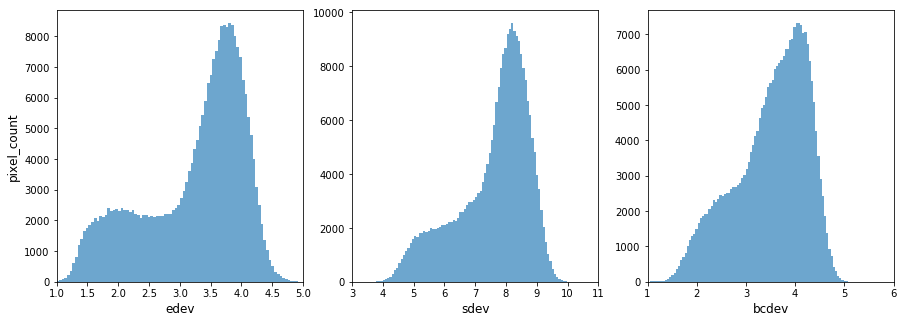

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
ax1.hist(edev_ravel[np.isfinite(edev_ravel)], bins=100, alpha=0.65)
ax2.hist(sdev_ravel[np.isfinite(sdev_ravel)], bins=100, alpha=0.65)
ax3.hist(bcdev_ravel[np.isfinite(bcdev_ravel)], bins=100, alpha=0.65)
ax1.set_xlabel('edev', fontsize=12)
ax1.set_xlim(1, 5)
ax2.set_xlabel('sdev', fontsize=12)
ax2.set_xlim(3, 11)
ax3.set_xlabel('bcdev', fontsize=12)
ax3.set_xlim(1, 6)
ax1.set_ylabel('pixel_count', fontsize=12)